In [0]:
!pip install stable_baselines[mpi]

     |████████████████████████████████| 256kB 9.4MB/s 
     |████████████████████████████████| 1.4MB 23.7MB/s 
  Created wheel for mpi4py: filename=mpi4py-3.0.3-cp36-cp36m-linux_x86_64.whl size=2074463 sha256=adf254d60df86df336f51074f03920dc04e398f387730b324af06ee9524d6dfa
  Stored in directory: /root/.cache/pip/wheels/18/e0/86/2b713dd512199096012ceca61429e12b960888de59818871d6
Successfully built mpi4py


In [0]:
!pip install 'tensorflow==1.13.2'

     |████████████████████████████████| 92.6MB 66kB/s 
     |████████████████████████████████| 368kB 35.0MB/s 
     |████████████████████████████████| 3.2MB 47.9MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


НОВАЯ ВЕРСИЯ 

In [0]:
import pandas as pd
df = pd.read_csv('result.csv')

In [0]:
df['time'] = 0

In [0]:
df = df[['time','dead_prob', 'Fever', 'Tiredness', 'Dry-Cough', 'Difficulty-in-Breathing',
       'Sore-Throat', 'Pains', 'Nasal-Congestion', 'Runny-Nose', 'Diarrhea',
       'Age_0-9', 'Age_10-19', 'Age_20-24', 'Age_25-59', 'Age_60+']]

In [0]:
from tqdm.auto import tqdm, trange

In [0]:
import gym
from gym import spaces
import numpy as np
import random

feature_w = np.array(
                      [
                        2,
                        0.12333333,
                        0.08333333,
                        0.14333333,
                        0.06333333,
                        0.19,
                        0.04,
                        0.02666667,
                        0.05,
                        0.01,
                        0.01,
                        0.1,
                        0.00666667,
                        0.02 
                      ]
                     )

class QueueModel(object):
    
    def __init__(self,dataset, queue_len, feature_weights):
        self.dataset = dataset
        self.queue_len = queue_len
        self.feature_weights = feature_weights
        self.x_axis_size = self.dataset.shape[0]
        self.y_axis_size = self.dataset.shape[1]
        self.patient = None
        self.wq = None
        self.previous_step_reward = -100 # np.random.randint(70)
        self.current_step_reward = None
        self.queue = np.zeros((
                                1,
                                self.y_axis_size,
                                1
                               ),dtype=float)
        
        self.tanh = lambda x: np.tanh(x)
        self.weight_updater = lambda x: x + x*np.random.uniform(0,0.2)
        self.weighted_queue = None
        self.reward = None
        self.max_other_features = None
        self.t = 1
        self.state_space = None
        self.new_patient = None
        self.action_space = None
        self.max_wait, self.severe = None, None
        self.ep_score = []

        for i in range(self.queue_len):
            self.queue = np.vstack((
                                    self.queue,
                                    self.dataset[[np.random.randint(
                                        1,
                                        self.x_axis_size,
                                        dtype=int)],:,:]
                                    ))
            
        self.queue = np.delete(
                                self.queue,
                                -1,
                                axis=0
                               )
        
    def update_patient_severity(self):

        self.queue[:,[1],:] = self.queue[:,[0],:]+0.2*np.random.random_sample((self.queue_len,1,1))

        self.queue[:,[1],:] = np.apply_along_axis(
                                                  np.tanh,
                                                  0,
                                                  self.queue[:,[1],:]
                                                  )
        return self
    
    
    def update(self):

        self.new_patient = self.dataset[
                                        [np.random.randint(
                                                            1,
                                                            self.x_axis_size,
                                                            dtype=int)
                                        ],:,:]

        self.queue = np.vstack((
                                self.queue,
                                self.dataset[
                                             [np.random.randint(
                                                                1,
                                                                self.x_axis_size,
                                                                dtype=int
                                                                )
                                             ],:,:]
                                ))
        
        self.queue[:,[0],:] += 1
        return self
    
    def observe(self):

        return self.queue
        
    def action(self, action):

        if action == 0:
            self.max_wait = np.argmax(self.queue[:,[0],:]) 
            self.queue = np.delete(
                                    self.queue,
                                    self.max_wait,
                                    axis=0
                                   )
        elif action == 1:
            self.max_severe = np.argmax(self.queue[:,[1],:])
            self.queue = np.delete(
                                    self.queue,
                                    self.max_severe,
                                    axis=0
                                   )
        elif action == 2:
            self.queue = np.delete(
                                    self.queue,
                                    -1,
                                    axis=0
                                   )
        else:
            self.wq = self.queue.copy()

            self.wq[:,2:,[0]] = np.multiply(
                                             self.wq[:,2:,[0]],
                                             self.feature_weights.reshape(1,self.y_axis_size-2,1)
                                            )
            
            self.max_other_features = np.argmax(np.sum(self.wq[:,2:,:],axis=1))

            self.queue = np.delete(
                                    self.queue,
                                    self.max_other_features,
                                    axis=0
                                   )
        return self
    
    def evaluate(self):
        # self.weighted_queue = self.queue.copy()

        # self.weighted_queue[:,2:,:] = np.multiply(
        #                                             self.weighted_queue[:,2:,:],
        #                                             self.feature_weights.reshape(1,self.y_axis_size-2,1)
        #                                             )
        # self.update_patient_severity()
        # self.current_step_reward = 1/np.sum(np.sum(self.queue,axis=1))
        # if self.current_step_reward < self.previous_step_reward:
        #     self.reward = abs(self.previous_step_reward - self.current_step_reward)*100
        # else:
        #     self.reward = abs(self.previous_step_reward - self.current_step_reward)*100
        # self.previous_step_reward = self.current_step_reward
        # self.ep_score.append(self.current_step_reward)
        return 100/np.sum(np.sum(self.queue,axis=1)) # self.reward
    
    def is_done(self):
        if self.t > 10: 
            return True
        else:
            return False
    


class CustomEnv(gym.Env):
    
    def __init__(self,dataset,queue_len,feature_w):
        
        self.dataset = dataset
        self.queue_len = queue_len
        self.feature_w = feature_w

        self.queue_game = QueueModel(
                                      dataset,
                                      queue_len,
                                      feature_w
                                      )
        
        self.y_axis_size = self.dataset.shape[1]
        self.action_space = spaces.Discrete(4)

        self.observation_space = spaces.Box(
                                            low=0,
                                            high=255,
                                            shape=(
                                                self.queue_len, 
                                                self.y_axis_size, 
                                                1
                                                )
                                            )

    def reset(self):

        del self.queue_game

        self.queue_game = QueueModel(
                                      self.dataset,
                                      self.queue_len,
                                      self.feature_w
                                     )
        
        return self.queue_game.queue
    
    def get_score(self):
        return self.queue_game.ep_score

    def step(self, action):

        self.queue_game.action(action)
        self.queue_game.update()
        reward = self.queue_game.evaluate()
        done = self.queue_game.is_done()
        obs = self.queue_game.observe()
        info = {}
        return obs, reward, done, info

In [0]:
import random
import gym
import numpy as np
from scipy.stats import mode
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, InputLayer
from keras.optimizers import Adam


EPISODES = 1000
QUEUE = 5
BATCH_SIZE = 32

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(InputLayer(input_shape=(16,1)))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.state_size*QUEUE, activation='elu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)

            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

temp_reward_mean = []
temp_actions_moda = []
ep = []

if __name__ == "__main__":
    env = CustomEnv(df.iloc[:100000, :16].to_numpy().reshape(100000,16,1),QUEUE,feature_w)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    done = False
    batch_size = BATCH_SIZE

    for e in tqdm(range(EPISODES)):
        state = env.reset()
        mean_reward = []
        actions = []
        for time in range(1):
            action = agent.act(state)
            actions.append(action)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -100
            mean_reward.append(reward)
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, time, agent.epsilon))
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        temp_reward_mean.append(np.mean(mean_reward))
        temp_actions_moda.append(int(mode(actions)[0]))

        ep.extend(env.get_score())

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
import matplotlib.pyplot as plt

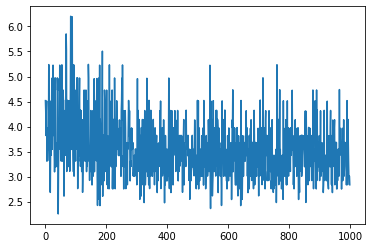

In [0]:
plt.plot(temp_reward_mean)

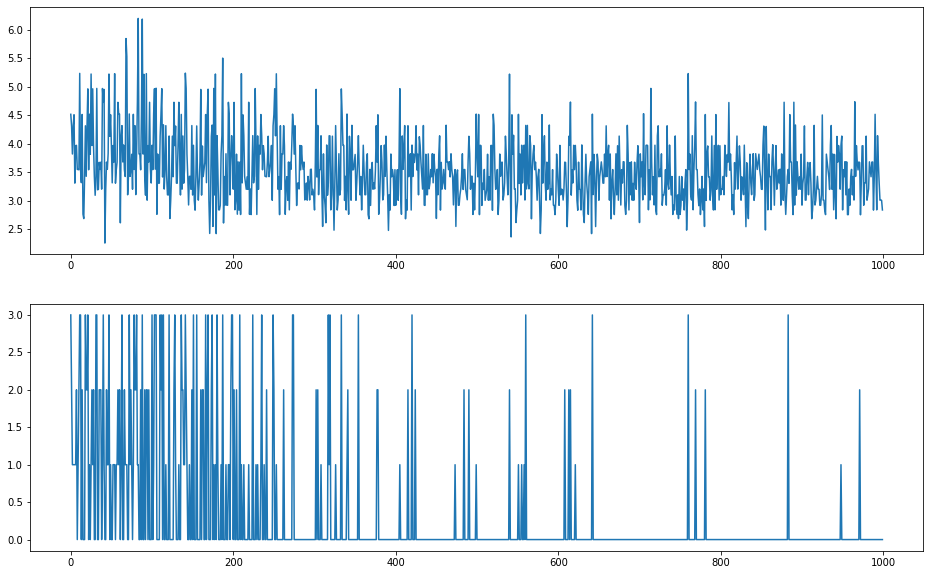

In [0]:
fig, axes = plt.subplots(2,1)

axes[0].plot(temp_reward_mean)
#axes[0].lines(temp_reward_mean)
axes[1].plot(temp_actions_moda)

fig.set_figwidth(16) 
fig.set_figheight(10) 

plt.show()